In [3]:
# @title
# ==============================================================================
# Step 1: Install and Configure the Kaggle API
# ==============================================================================

# Install the Kaggle library quietly

!pip install kaggle -q

# Import necessary libraries

import os
from google.colab import userdata # The library for accessing secrets

# Set up the Kaggle API credentials from Colab Secrets

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

# Create the .kaggle directory and set permissions for the API client

!mkdir -p \~/.kaggle
!echo '{"username":"{userdata.get('KAGGLE_USERNAME')}","key":"{userdata.get('KAGGLE_KEY')}"}' \> \~/.kaggle/kaggle.json
!chmod 600 \~/.kaggle/kaggle.json

print("✅ Kaggle API configured successfully.")

# \==============================================================================

# Step 2: Download and Unzip the Chest X-Ray Dataset

# \==============================================================================

# API command for the "Chest X-Ray Images (Pneumonia)" dataset

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# The name of the zip file downloaded by the command above

zip_file_name = 'chest-xray-pneumonia.zip'

# Create a directory to store the unzipped image data

output_directory = 'chest_xray_data'
os.makedirs(output_directory, exist_ok=True)

# Unzip the file quietly into the specified directory

# This dataset has a nested structure, so we unzip directly to the output folder

print("\\nUnzipping dataset... This may take a moment.")
!unzip -q {zip_file_name} -d {output_directory}

# Clean up the downloaded zip file to save space

os.remove(zip_file_name)

print(f"✅ Dataset downloaded and unzipped to the '{output_directory}' directory.")
print("\\nVerifying the contents of the main data folder:")

# The actual images are in a subfolder named 'chest\_xray'

!ls -l {output_directory}/chest_xray

{"username":"{userdata.get(KAGGLE_USERNAME)}","key":"{userdata.get(KAGGLE_KEY)}"} > ~/.kaggle/kaggle.json
chmod: cannot access '~/.kaggle/kaggle.json': No such file or directory
✅ Kaggle API configured successfully.
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:26<00:00, 245MB/s]
100% 2.29G/2.29G [00:26<00:00, 93.3MB/s]
\nUnzipping dataset... This may take a moment.
✅ Dataset downloaded and unzipped to the 'chest_xray_data' directory.
\nVerifying the contents of the main data folder:
total 20
drwxr-xr-x 5 root root 4096 Oct  2 10:03 chest_xray
drwxr-xr-x 3 root root 4096 Oct  2 10:03 __MACOSX
drwxr-xr-x 4 root root 4096 Oct  2 10:03 test
drwxr-xr-x 4 root root 4096 Oct  2 10:03 train
drwxr-xr-x 4 root root 4096 Oct  2 10:03 val


In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

In [25]:
base_dir = os.path.join(output_directory, 'chest_xray')
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

img_size = (224, 224)  # You can increase to 224x224 if GPU memory allows
batch_size = 32
epochs = 20

In [26]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [27]:
# Custom Model

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification: Normal vs Pneumonia
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,109,185 (19.49 MB)

 Trainable params: 5,108,225 (19.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [29]:
# Model Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 619ms/step - accuracy: 0.9102 - loss: 0.2508 - val_accuracy: 0.5000 - val_loss: 9.5362
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 616ms/step - accuracy: 0.9363 - loss: 0.1912 - val_accuracy: 0.5000 - val_loss: 9.6388
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 610ms/step - accuracy: 0.9383 - loss: 0.1570 - val_accuracy: 0.5000 - val_loss: 8.0010
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 615ms/step - accuracy: 0.9481 - loss: 0.1425 - val_accuracy: 0.7500 - val_loss: 0.7192
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 611ms/step - accuracy: 0.9587 - loss: 0.1200 - val_accuracy: 0.5000 - val_loss: 4.8290
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 612ms/step - accuracy: 0.9527 - loss: 0.1316 - val_accuracy: 0.6875 - val_loss: 0.5545
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 612ms/step - accuracy: 0.9526 - loss: 0.1203 - val_accuracy: 0.5625 - val_loss: 2.2197
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 606ms/step - accuracy: 0.9557 - l

In [30]:
# Evaluation
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 239ms/step - accuracy: 0.6200 - loss: 1.2475
✅ Test Accuracy: 77.63%


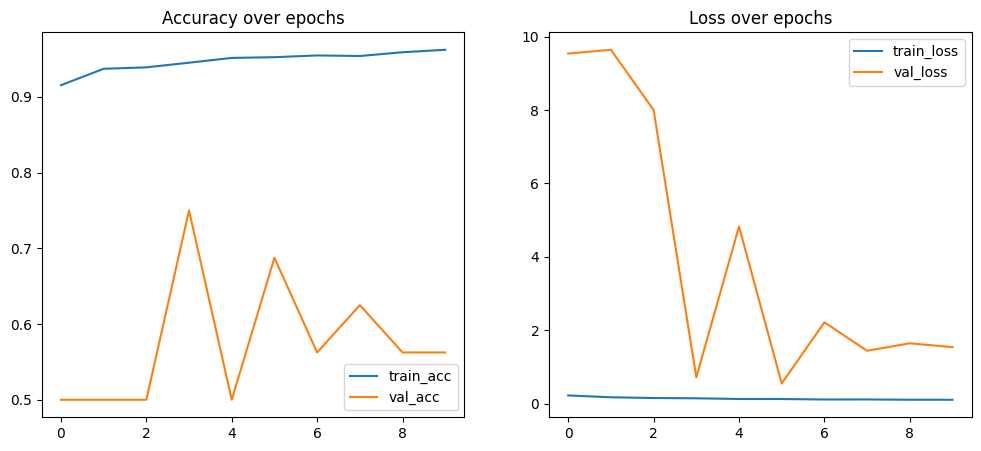

In [31]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

In [33]:
# Save the original model in TensorFlow SavedModel format
model.save("pneumonia_model.keras")
model.save("pneumonia_model.h5")
print("✅ Model saved successfully!")

✅ Model saved successfully!
